In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.impute import SimpleImputer

In [2]:
flights = pd.read_csv('../data/ntsb-sample-2013.csv')
merged = pd.read_csv('../data/master.csv')
# flights = pd.read_csv('/content/ntsb-sample-2013.csv')
# merged = pd.read_csv('/content/master.csv')

<ipython-input-2-4d6f714942d2>:4: DtypeWarning: Columns (1,39,40,41,42,43,44,45,48,49,50,51,54,55,62) have mixed types. Specify dtype option on import or set low_memory=False.
  merged = pd.read_csv('/content/master.csv')


### Drop columns we won't use

In [3]:
# Dropped columns and reasons for dropping them

# Not relevant
flights.drop(['Mkey', 'ReportNo', 'N#', 'SerialNumber', 'ReportType', 'ReportStatus', 'RepGenFlag',
              'MostRecentReportType', 'OriginalPublishedDate', 'DocketOriginalPublishedDate',
              'Operator', 'EventID', 'NtsbNo', 'DocketUrl', 'ReportUrl'], axis=1, inplace=True)

# (Almost) all rows have same value
flights.drop(['Country', 'Mode', 'HasSafetyRec', ], axis=1, inplace=True)

# Redundant
flights.drop(['HighestInjuryLevel'], axis=1, inplace=True)

In [4]:
flights['EventDate'] = pd.to_datetime(flights['EventDate'])
flights.fillna({'OnboardInjuryCount': 0, 'OnGroundInjuryCount': 0}, inplace=True)
flights['OnboardInjuryCount'] = flights['OnboardInjuryCount'].astype(int)
flights['OnGroundInjuryCount'] = flights['OnGroundInjuryCount'].astype(int)

In [ ]:
flights.columns

Index(['EventType', 'EventDate', 'City', 'State', 'FatalInjuryCount',
       'SeriousInjuryCount', 'MinorInjuryCount', 'OnboardInjuryCount',
       'OnGroundInjuryCount', 'ProbableCause', 'Findings', 'Latitude',
       'Longitude ', 'Make', 'Model', 'AirCraftCategory', 'AirportID',
       'AirportName', 'AmateurBuilt', 'NumberOfEngines', 'EngineType',
       'Scheduled', 'PurposeOfFlight', 'FAR', 'AirCraftDamage',
       'WeatherCondition', 'BroadPhaseofFlight'],
      dtype='object')

In [ ]:
flights.isna().sum()

,0
EventType,0
EventDate,0
City,0
State,2
FatalInjuryCount,0
SeriousInjuryCount,0
MinorInjuryCount,0
OnboardInjuryCount,5
OnGroundInjuryCount,6
ProbableCause,1


### Time Series Prediction

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [34]:
# Create sequences for LSTM
def df_to_X_y(data, window_size=3):
  X, y = [], []
  for i in range(len(data) - window_size):
    X.append(data[i:i + window_size, 0])
    y.append(data[i + window_size, 0])
  return np.array(X), np.array(y)


# LSTM model
def LSTMmodel(data, window_size):

  X, y = df_to_X_y(data, window_size)

  # Reshape input to be [samples, time steps, features] for LSTM
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))

  # Split data into training and testing sets
  train_size = int(len(X) * 0.80)
  test_size = len(X) - train_size
  X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
  y_train, y_test = y[0:train_size], y[train_size:len(y)]

  # Scale data
  scaler_X = MinMaxScaler()
  scaler_Y = MinMaxScaler()

  X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
  X_test_scaled = scaler_X.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

  y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1, 1).reshape(-1, 1))
  y_test_scaled = scaler_Y.transform(y_test.reshape(-1, 1).reshape(-1, 1))

  # # Build the LSTM model (for large data)
  # model = Sequential()
  # model.add(InputLayer((window_size, 1)))
  # model.add(LSTM(64))
  # model.add(Dense(8, activation='relu'))
  # model.add(Dropout(0.2))
  # model.add(Dense(1))
  # model.compile(optimizer='adam', loss='mse')

  # # Train the model
  # model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=64, verbose=0)

  # Build the LSTM model (for small data)
  model = Sequential()
  model.add(InputLayer((window_size, 1)))
  model.add(LSTM(16))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  # Train the model
  model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=8, verbose=0)

  # Make predictions
  train_predict = model.predict(X_train_scaled)
  test_predict = model.predict(X_test_scaled)

  # Invert predictions to original scale
  train_predict = scaler_Y.inverse_transform(train_predict)
  test_predict = scaler_Y.inverse_transform(test_predict)

  return X_train, X_test, y_train, y_test, train_predict, test_predict

#### By month

In [9]:
flights.groupby(pd.Grouper(key='EventDate', freq='ME'))['EventDate'].count().reset_index(name='AccidentCount')

,EventDate,AccidentCount
0,2013-01-31 00:00:00+00:00,69
1,2013-02-28 00:00:00+00:00,81
2,2013-03-31 00:00:00+00:00,105
3,2013-04-30 00:00:00+00:00,98
4,2013-05-31 00:00:00+00:00,135
5,2013-06-30 00:00:00+00:00,155
6,2013-07-31 00:00:00+00:00,153
7,2013-08-31 00:00:00+00:00,152
8,2013-09-30 00:00:00+00:00,125
9,2013-10-31 00:00:00+00:00,107


In [ ]:
# Aggregate accidents by month
accidents_by_month = flights.groupby(pd.Grouper(key='EventDate', freq='ME'))['EventDate'].count().reset_index(name='AccidentCount')

# Prepare data for LSTM
data = accidents_by_month['AccidentCount'].values.reshape(-1, 1)

window_size = 3  # Number of previous months to consider

X_train, X_test, y_train, y_test, train_predict, test_predict = LSTMmodel(data, window_size)

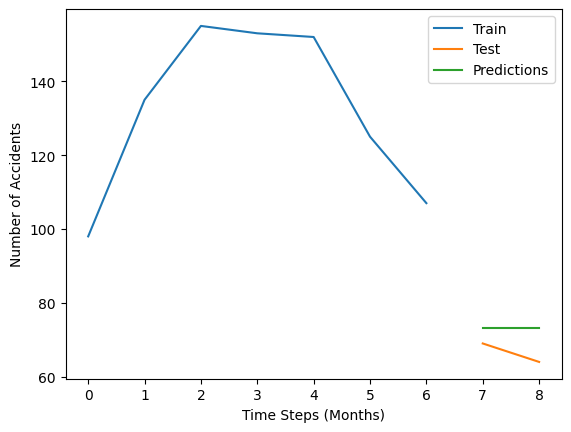

In [ ]:
# Plotting
plt.plot(y_train, label='Train')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predict, label='Predictions')
plt.xlabel('Time Steps (Months)')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()

In [35]:
post_covid = merged.loc[merged['ev_year'] >= 2020]
merged_accidents_by_month = post_covid.groupby(['ev_year', 'ev_month']).size().reset_index(name='Count')

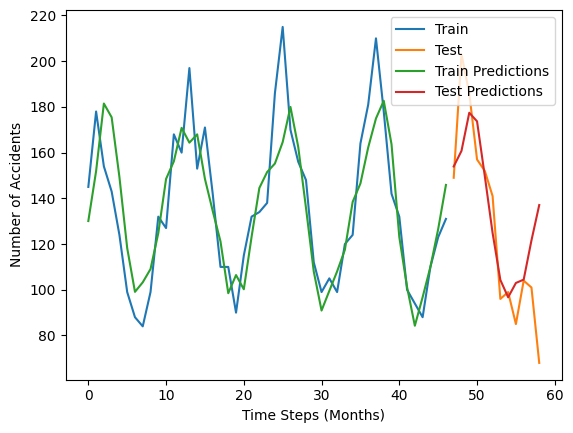

In [52]:
# Prepare data for LSTM
data = merged_accidents_by_month['Count'].values.reshape(-1, 1)

window_size = 5  # Number of previous months to consider

X_train, X_test, y_train, y_test, train_predict, test_predict = LSTMmodel(data, window_size)

plt.plot(y_train, label='Train')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
plt.plot(train_predict, label='Train Predictions')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predict, label='Test Predictions')

plt.xlabel('Time Steps (Months)')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()

#### By day

In [ ]:
flights.groupby(pd.Grouper(key='EventDate', freq='D'))['EventDate'].count().reset_index(name='AccidentCount')

,EventDate,AccidentCount
0,2013-01-01 00:00:00+00:00,2
1,2013-01-02 00:00:00+00:00,8
2,2013-01-03 00:00:00+00:00,1
3,2013-01-04 00:00:00+00:00,2
4,2013-01-05 00:00:00+00:00,2
...,...,...
360,2013-12-27 00:00:00+00:00,2
361,2013-12-28 00:00:00+00:00,2
362,2013-12-29 00:00:00+00:00,4
363,2013-12-30 00:00:00+00:00,1


In [ ]:
# Aggregate accidents by month
accidents_by_month = flights.groupby(pd.Grouper(key='EventDate', freq='D'))['EventDate'].count().reset_index(name='AccidentCount')

# Prepare data for LSTM
data = accidents_by_month['AccidentCount'].values.reshape(-1, 1)

window_size = 3  # Number of previous days to consider

X_train, X_test, y_train, y_test, train_predict, test_predict = LSTMmodel(data, window_size)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1227
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1121
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0859
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0748
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0571
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0407
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0398
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0405
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0368 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0404
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0446
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0430
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0378
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0401 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0393
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


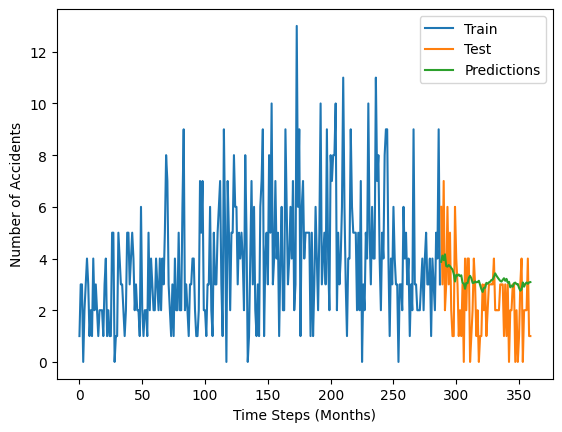

In [ ]:
# Plotting
plt.plot(y_train, label='Train')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predict, label='Predictions')
plt.xlabel('Time Steps (Months)')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()